In [65]:
!pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 MB 19.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 2.2.0.post100
    Uninstalling torch-2.2.0.post100:
      Successfully uninstalled torch-2.2.0.post100


In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# NN Packages
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

# **Function Definition**

In [39]:
def validation_loss(validation_dataloader, criterion, model):
    ''' 

    This function will be used to calculate the validation loss
    
    '''
    model.eval()
    validation_loss = 0.0

    with torch.no_grad():
        for batch in validation_dataloader:
            # Get the inputs and labels
            inputs, labels = batch

            # Forward pass
            outputs = model(inputs)

            # Calculate the validation loss
            loss = criterion(outputs, labels)
            validation_loss += loss.item()

    # Calculate the average validation loss
    validation_loss /= len(validation_dataloader)

    return validation_loss

In [4]:
df = pd.read_csv('data_for_churn_analysis.csv')

In [5]:
df.shape

(104143, 18)

In [6]:
df.head()

,device,first_payment_amount,age,city,number_of_cards,payments_initiated,payments_failed,payments_completed,payments_completed_amount_first_7days,reward_purchase_count_first_7days,coins_redeemed_first_7days,is_referral,visits_feature_1,visits_feature_2,given_permission_1,given_permission_2,user_id,is_churned
0,samsung,0,20.0,Ahmedabad,2.0,1.0,0.0,1.0,0.0,NaN,0.0,False,3.0,0.0,1,0,269438,0
1,xiaomi,0,20.0,Surat,1.0,1.0,0.0,1.0,0.0,NaN,0.0,True,0.0,0.0,1,0,139521,0
2,xiaomi,0,20.0,Kullu,1.0,2.0,1.0,1.0,0.0,0.0,0.0,True,0.0,0.0,0,1,307352,0
3,oneplus,0,20.0,Mumbai,2.0,4.0,1.0,2.0,322.0,2.0,20.0,False,0.0,0.0,1,1,456424,0
4,apple,0,20.0,Pune,2.0,1.0,0.0,1.0,0.0,0.0,0.0,False,0.0,1.0,1,1,398779,0


In [7]:
df['is_churned'].value_counts(normalize=True)

is_churned
0    0.713192
1    0.286808
Name: proportion, dtype: float64

In [8]:
df.columns

Index(['device', 'first_payment_amount', 'age', 'city', 'number_of_cards',
       'payments_initiated', 'payments_failed', 'payments_completed',
       'payments_completed_amount_first_7days',
       'reward_purchase_count_first_7days', 'coins_redeemed_first_7days',
       'is_referral', 'visits_feature_1', 'visits_feature_2',
       'given_permission_1', 'given_permission_2', 'user_id', 'is_churned'],
      dtype='object')

## **Deep neural networks (DNNs) for propensity score matching**

1. **Impact of Referrals on Customer Acquisition and Retention**:
   - Research Question: Do customers acquired through referrals (`is_referral`) exhibit different behaviors and retention rates compared to non-referred customers?
   - Treatment: Customer acquisition through referrals
   - Outcome: Customer behavior (e.g., `payments_initiated`, `payments_completed`, `visits_feature_1`, `visits_feature_2`) and churn (`is_churned`)
   - Potential Confounders: `device`, `age`, `city`, `number_of_cards`, `payments_failed`, `payments_completed_amount_first_7days`, `reward_purchase_count_first_7days`, `coins_redeemed_first_7days`, `given_permission_1`, `given_permission_2`

### **Preprocessing**

In [10]:
# Preprocessing
obj_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()
for col in obj_cols:
    df[col] = le.fit_transform(df[col])

df['is_referral'] = df['is_referral'].astype('int')


In [11]:
# Dealing with missing values
missing_cols = df.columns[df.isna().any()].tolist()
for col in missing_cols:
    df[col] = df[col].fillna(df[col].mean())

### **Data Split**

In [12]:
confounders = [
    'device',
    'age',
    'city',
    'number_of_cards',
    'payments_failed',
    'payments_completed_amount_first_7days',
    'reward_purchase_count_first_7days',
    'coins_redeemed_first_7days',
    'given_permission_1',
    'given_permission_2',
    'is_referral' # treatment
]

# 
y = df['is_churned']
X = df[confounders]

In [78]:
(X['age'] - X['age'].mean()) / X['age'].std()

0        -1.623287
1        -1.623287
2        -1.623287
3        -1.623287
4        -1.623287
            ...   
104138    0.000000
104139    0.000000
104140    0.000000
104141    0.000000
104142    0.000000
Name: age, Length: 104143, dtype: float64

In [68]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.Normalize((0.5,), (0.5,))
])

# converting to pytorch tensors
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
X_val = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
y_val = torch.tensor(y_val.to_numpy(), dtype=torch.float32)

# Tensor dataset and DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_val, y_val)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=1, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=1, transform=transform)

TypeError: DataLoader.__init__() got an unexpected keyword argument 'transform'

In [57]:
# Model Architecture
model = nn.Sequential(
                    nn.Linear(in_features=11, out_features=256), # 3072 trainable parameters
                    nn.ReLU(),
                    nn.Dropout(p=0.3),
                    nn.Linear(in_features=256, out_features=128), # 32896 trainable parameters
                    nn.ReLU(),
                    nn.Dropout(p=0.3),
                    nn.Linear(in_features=128, out_features=64),  # 8256 trainable parameters
                    nn.ReLU(),
                    nn.Dropout(p=0.5),
                    nn.Linear(in_features=64, out_features=1) # 65 trainable parameters
                )

optimizer = optim.Adam(model.parameters(), lr=0.1)
criterion = nn.MSELoss()

In [58]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
num_params

44289

In [60]:
X_train

tensor([[ 25.,  34., 438.,  ...,   1.,   1.,   1.],
        [ 67.,  31.,   5.,  ...,   1.,   0.,   0.],
        [ 69.,  39., 438.,  ...,   1.,   0.,   0.],
        ...,
        [ 42.,  67., 259.,  ...,   1.,   0.,   1.],
        [  2.,  22.,  63.,  ...,   1.,   1.,   0.],
        [ 54.,  26., 105.,  ...,   1.,   1.,   0.]])

**Training loop**

In [ ]:
# Compute mean and standard deviation for each feature
feature_means = data.mean(dim=0)
feature_stds = data.std(dim=0)

# Define a transform to standardize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(feature_means, feature_stds)
])

In [59]:
#### Number of epochs
epochs = 15

#### Initializing empty lists to store results
epoch_val_loss_lst = []
epoch_train_loss_lst = []
epoch_num_lst = []

for epoch in range(epochs):

    # initializing epoch_loss to zero at the beginning of every epoch
    epoch_loss = 0

    for batch_features, batch_labels in train_dataloader:

        # forward pass
        optimizer.zero_grad()
        pred = model(batch_features)
        loss = criterion(pred, batch_labels) 

        # backpropagating
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * batch_features.size(0)  # Accumulate batch loss
    
    # Calculate average epoch loss
    epoch_loss /= len(train_dataset)

    ########### Validation loss
    val_loss = validation_loss(validation_dataloader=test_dataloader, criterion=criterion, model=model)


    epoch_train_loss_lst.append(epoch_loss)
    epoch_num_lst.append(epoch)
    epoch_val_loss_lst.append(val_loss)

    #print(f"Validation Loss: {validation_loss}")
    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss}, Validation Loss: {val_loss}')

Epoch 1/15, Training Loss: 4874.565760340921, Validation Loss: 0.2037258006506435


KeyboardInterrupt: 

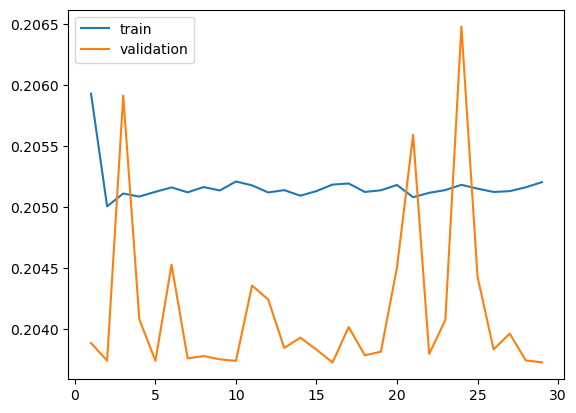

In [52]:
#TODO: Write code to plot the training error (MER) over epochs
plt.plot(epoch_num_lst, epoch_train_loss_lst, label='train')
plt.plot(epoch_num_lst, epoch_val_loss_lst, label='validation')
plt.legend();